In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#using code from here https://www.kaggle.com/anezka/cnn-with-keras-for-humpback-whale-id

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
import zipfile as zf
import os
import csv
import gc
import operator
import random
#from sklearn.cross_validation import train_test_split
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from random import shuffle
from IPython.display import Image
from pathlib import Path

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.utils import np_utils
import keras.backend as K
from keras.models import Sequential
from keras import optimizers

Using TensorFlow backend.


In [ ]:
#load in the train.csv and look at some of the entries

In [3]:
trainData = pd.read_csv("../input/humpback-whale-identification/train.csv")

In [5]:
trainData.sample(15)

,Image,Id
9541,60a300f1e.jpg,w_eca61e6
21872,dbfe0e2b8.jpg,w_23a388d
2318,17b05d20d.jpg,w_1ca9ab1
15886,a003f2cd4.jpg,new_whale
16814,a8ec62b0e.jpg,new_whale
11190,71a0c3d2b.jpg,w_3bdf2c6
25230,fe8abf4b1.jpg,w_72aa314
5126,34a671ade.jpg,new_whale
12889,8223ae8a6.jpg,w_4af7c01
11034,6ffdc2f7a.jpg,w_afcf807


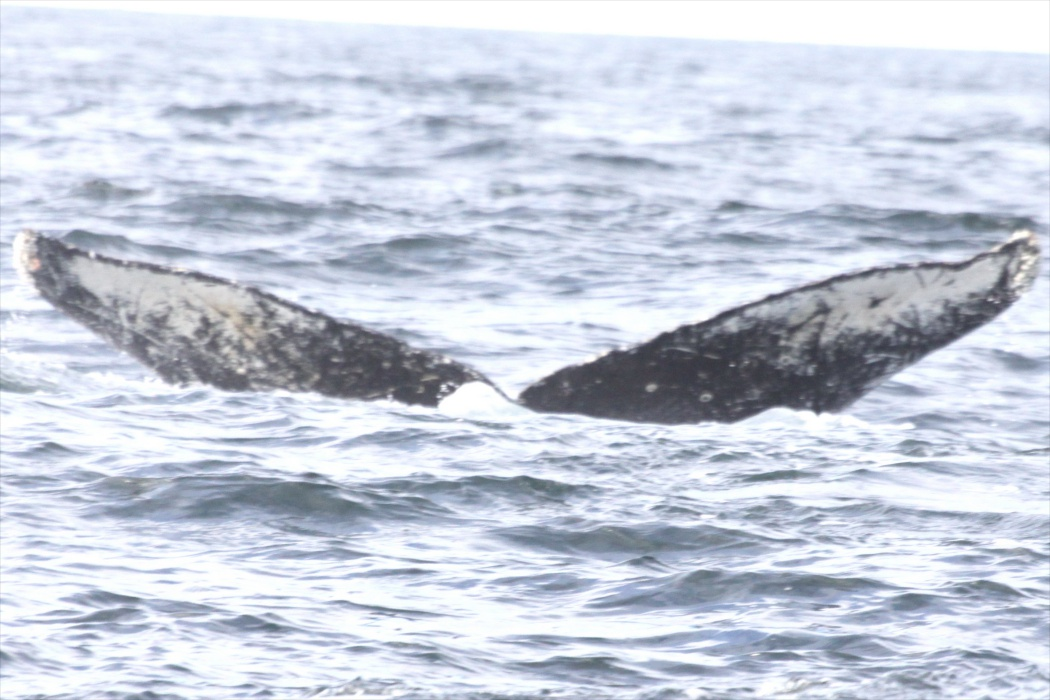

In [6]:
#look at an image from training directory
Image(filename="../input/humpback-whale-identification/train/"+random.choice(trainData['Image'])) 

In [10]:
def prepareY(Y): #labels

    values = array(Y)
    print(values.shape)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    print(integer_encoded)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    print(onehot_encoded)

    y = onehot_encoded
    print(y.shape)
    return y, label_encoder
   

In [12]:
def prepareImages(data, m, dataset):
    
    print("Preparing images")
    
    X_train = np.zeros((m, 100, 100, 3))
    
    count = 0
    
    for fig in data['Image']:
        #load images into images of size 100x100x3
        img = image.load_img("../input/humpback-whale-identification/"+dataset+"/"+fig, target_size=(100, 100, 3))
        x = image.img_to_array(img)
        #x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X_train[count] = x
        if (count%500 == 0):
            print("Processing image: ", count+1, ", ", fig)
        count += 1
    
    count = 0
    
    print("Finished!")
            
    return X_train

In [16]:
X = prepareImages(trainData, trainData.shape[0], "train")

#put all the values of the training data in the range between 0 and 1
X /= 255

print("Shape X-train: ", X.shape)

Preparing images
Processing image:  1 ,  0000e88ab.jpg
Processing image:  501 ,  04c72257b.jpg
Processing image:  1001 ,  09cacb84d.jpg
Processing image:  1501 ,  0ef961892.jpg
Processing image:  2001 ,  141b56a1a.jpg
Processing image:  2501 ,  199a417aa.jpg
Processing image:  3001 ,  1ec170983.jpg
Processing image:  3501 ,  23f084b93.jpg
Processing image:  4001 ,  29163ad0b.jpg
Processing image:  4501 ,  2e0fab120.jpg
Processing image:  5001 ,  3347515d9.jpg
Processing image:  5501 ,  3842d71dc.jpg
Processing image:  6001 ,  3d7f4c7d5.jpg
Processing image:  6501 ,  425f763ca.jpg
Processing image:  7001 ,  4714400cd.jpg
Processing image:  7501 ,  4c082fbdf.jpg
Processing image:  8001 ,  50c683e23.jpg
Processing image:  8501 ,  560d986ad.jpg
Processing image:  9001 ,  5b68c83ed.jpg
Processing image:  9501 ,  60410f111.jpg
Processing image:  10001 ,  654951f81.jpg
Processing image:  10501 ,  6a572256c.jpg
Processing image:  11001 ,  6f96f55b6.jpg
Processing image:  11501 ,  74da2b511.jpg

In [19]:
Y = trainData['Id']

print("Shape Y-train: ", Y.shape)

#The next lines are used for testing - not necessary for the code
labels = trainData['Id'].unique()
print("Labels in data set: ", labels.shape)
labelsTrain = Y.unique()
print("Labels in training set: ", labelsTrain.shape)

y, label_encoder = prepareY(Y)

Shape Y-train:  (25361,)
Labels in data set:  (5005,)
Labels in training set:  (5005,)
(25361,)
[4786 3808  662 ... 3671 3103    0]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
(25361, 5005)


In [24]:
model = Sequential()

model.add(Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0', input_shape = (100, 100, 3)))

model.add(BatchNormalization(axis = 3, name = 'bn0'))
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2), name='max_pool'))
model.add(Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
model.add(Activation('relu'))
model.add(AveragePooling2D((3, 3), name='avg_pool'))

model.add(Flatten())
model.add(Dense(500, activation="relu", name='rl'))
model.add(Dropout(0.8))
model.add(Dense(y.shape[1], activation='softmax', name='sm'))

print(model.output_shape)

#opt = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

(None, 5005)


In [25]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 94, 94, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 94, 94, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 47, 47, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 45, 45, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 45, 45, 64)        0         
_________________________________________________________________
avg_pool (AveragePooling2D)  (None, 15, 15, 64)       

In [ ]:
history = model.fit(X, y, epochs=10, batch_size=100, verbose=1)
gc.collect()

Epoch 1/10
25361/25361 [==============================] - 424s 17ms/step - loss: 6.2030 - accuracy: 0.3792
Epoch 2/10
25361/25361 [==============================] - 419s 17ms/step - loss: 5.9289 - accuracy: 0.3811
Epoch 3/10
25361/25361 [==============================] - 427s 17ms/step - loss: 5.8062 - accuracy: 0.3811
Epoch 4/10
25361/25361 [==============================] - 423s 17ms/step - loss: 5.7601 - accuracy: 0.3811
Epoch 5/10
25361/25361 [==============================] - 424s 17ms/step - loss: 5.7152 - accuracy: 0.3811
Epoch 6/10
25361/25361 [==============================] - 426s 17ms/step - loss: 5.6950 - accuracy: 0.3811
Epoch 7/10
19800/25361 [======================>.......] - ETA: 1:35 - loss: 5.6782 - accuracy: 0.3784